In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text          # needed for loading bert from hub
from official.nlp import optimization   # to create AdamW optimizer
from matplotlib import pyplot as plt
from collections import defaultdict

tf.get_logger().setLevel('ERROR')
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from preprocessing import preprocess, id2vec

raw_ds = preprocess('tfcm')

Total number of news: 30339
Maximum number of news for each group in training set: 64
Minimum number of news for each group in training set: 3
Maximum number of news for each group in test set: 26
Minimum number of news for each group in test set: 3
Maximum number of times a news appears in training set: 22
Minimum number of times a news appears in training set: 0
Maximum number of times a news appears in test set: 11
Minimum number of times a news appears in test set: 0


In [3]:
valueRange = set(raw_ds['score'].values())
len(raw_ds['score']), len(valueRange)

(24160, 52)

In [9]:
countLine = 0
countID = defaultdict(int)
flag = False
countInLine = 0
flagIn = False
for line in raw_ds['test']:
    for ID in line:
        if ID not in raw_ds['score']:
            countID[ID] += 1
            flag = True
        else:
            flagIn = True
    if flag:
        countLine += 1
        flag = False
    if flagIn:
        countInLine += 1
        flag1 = False
countLine, countInLine, len(raw_ds['test']), len(countID)

(2460, 2590, 3000, 6179)

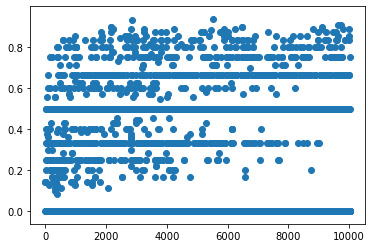

In [5]:
plt.scatter(range(len(raw_ds['score'])), raw_ds['score'].values())

In [19]:
np.array(raw_ds['train_reg'])[:,0]

array(['5187439', '176694', '175203', ..., '5539285', '179996', '9321204'],
      dtype='<U32')

In [3]:
train_data = np.vectorize(id2text:= lambda x: raw_ds['news'][x])(np.array(raw_ds['train_reg'])[:,0])
train_label = np.array(raw_ds['train_reg'])[:,1].astype(np.float32)
valid_data = np.vectorize(id2text)(np.array(raw_ds['valid_reg'])[:,0])
valid_label = np.array(raw_ds['valid_reg'])[:,1].astype(np.float32)

In [6]:
valid_label

array([1., 0., 0., ..., 0., 1., 1.], dtype=float32)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_label))
len(train_ds), len(valid_ds)

(21744, 2416)

In [8]:
# tf.compat.v1.disable_eager_execution()
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 512
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
num_train = len(train_ds)
num_valid = len(valid_ds)
num_train, num_valid

(680, 76)

In [9]:
for x, y in train_ds.take(1):
    print(x[0].shape, x[1].shape, y.shape)
y

(32,) (32,) (32,)


<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. ,
       1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0. , 1. ,
       1. , 0. , 1. , 1. , 0. , 1. ], dtype=float32)>

In [10]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.metrics.MeanAbsoluteError()
epochs = 5
num_train_steps = num_train * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')
title_units = 32
content_units = 128

In [11]:
from model import tfcm

regressioner = tfcm.build_regression_model(title_units, content_units, fine_tune=False)

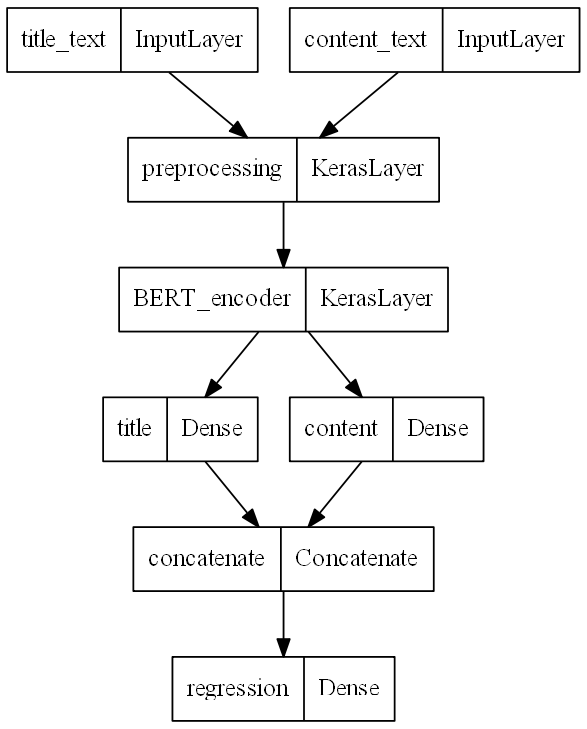

In [12]:
from keras.utils import plot_model

os.environ["PATH"] += os.pathsep + 'D:/Graphviz/2.38/bin/'
plot_model(regressioner, to_file='model/structure_regressioner.png', dpi=128)

In [13]:
regressioner.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = regressioner.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[callbacks])

Epoch 1/5
680/680 [==============================] - 683s 987ms/step - loss: 0.2322 - mean_absolute_error: 0.4446 - val_loss: 0.2214 - val_mean_absolute_error: 0.4519
Epoch 2/5
680/680 [==============================] - 717s 1s/step - loss: 0.2111 - mean_absolute_error: 0.4274 - val_loss: 0.2145 - val_mean_absolute_error: 0.4432
Epoch 3/5
680/680 [==============================] - 704s 1s/step - loss: 0.2085 - mean_absolute_error: 0.4249 - val_loss: 0.2089 - val_mean_absolute_error: 0.4348
Epoch 4/5
680/680 [==============================] - 704s 1s/step - loss: 0.2066 - mean_absolute_error: 0.4235 - val_loss: 0.2062 - val_mean_absolute_error: 0.4293
Epoch 5/5
680/680 [==============================] - 703s 1s/step - loss: 0.2051 - mean_absolute_error: 0.4227 - val_loss: 0.2040 - val_mean_absolute_error: 0.4219


In [18]:
test_data = np.vectorize(id2text)(np.array(list(raw_ds['test_reg'])))
test_label = regressioner.predict(test_data)
test_label

194/194 [==============================] - 165s 854ms/step


array([[0.6369547 ],
       [0.72742546],
       [0.6899878 ],
       ...,
       [0.6193234 ],
       [0.7055019 ],
       [0.6910982 ]], dtype=float32)

In [ ]:
raw_ds = preprocess('bert')